## **Data Processing**

**What is data Processing?**

Data processing is the process where make data structured in a which can be feeded to model to predict the target.

**Steps**

* We wil look for the feature and display the features.
* We will scale the data using sklearn.preprocessing.StandardScaler.
* We will not create Pipeline Classes as the data does not have to much feature
* Then we will go to model building.

**Importing all the basic library**

In [1]:
# all the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# these are all the mertics to evaluate the model
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

# all the prepocessing classes and functions
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# all the models 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')

**Loading the datasets<br> We will use only 16-03-2022 Data to make the model**

In [2]:
df = pd.read_csv('data/clean_data_20220316.csv')

In [3]:
df.head()

,Unnamed: 0,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,Liquidity_Ratio,volatility
0,0,Bitcoin,BTC,40859.460000,0.022,0.030,0.055,35390763321,770991461396,0.045903,Stable
1,1,Ethereum,ETH,2744.410000,0.024,0.034,0.065,19748695312,327104429349,0.060374,Stable
2,2,Tether,USDT,1.000000,-0.001,-0.001,0.000,57934969077,79965155138,0.724503,High
3,3,BNB,BNB,383.430000,0.018,0.028,0.004,1395853984,64043816800,0.021795,Stable
4,4,USD Coin,USDC,0.999874,-0.001,0.000,-0.000,3872273611,52222137400,0.074150,Stable


We can see that we have no usefull columns named = ["Unnamed: 0", "coin", "symbol", "price"].<br>
* We will drop the string columns cause they do not have relation and help in model building.
* Droping price columns because it does not show the coin feature as market_cap shows it better


In [4]:
drop_cols = ["Unnamed: 0", "coin", "symbol", "price", "Liquidity_Ratio"] # droping Liquidity_Ratio cause it will create biasness
for column in drop_cols:
    df.drop(column, inplace=True, axis=1)
    print(f"Column {column} is dropped.")

Column Unnamed: 0 is dropped.
Column coin is dropped.
Column symbol is dropped.
Column price is dropped.
Column Liquidity_Ratio is dropped.


In [5]:
df.head()

,1h,24h,7d,24h_volume,mkt_cap,volatility
0,0.022,0.030,0.055,35390763321,770991461396,Stable
1,0.024,0.034,0.065,19748695312,327104429349,Stable
2,-0.001,-0.001,0.000,57934969077,79965155138,High
3,0.018,0.028,0.004,1395853984,64043816800,Stable
4,-0.001,0.000,-0.000,3872273611,52222137400,Stable


**Handling Duplicates**

In [6]:
df.duplicated().sum()

np.int64(0)

### Type of Features

**Numeric Features**

In [7]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features), num_features)

Num of Numerical Features : 5 ['1h', '24h', '7d', '24h_volume', 'mkt_cap']


**Categorical Features**

In [8]:
# the one categorical feature which is displayed in output is not feature it is target for our problem statement
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features), cat_features)

Num of Categorical Features : 1 ['volatility']


Now we will create X and y in test and train the transform the data

### Split into Train and test data

- **Do you know why we split the train and test dataset?**
> The train test split technique can be used for classification and regression problems to test machine learning algorithms. The procedure takes the given dataset and splits it into two subsets: ```Training data/train set:``` it is used to train the algorithm and fit the machine learning model
then we have ```test data/test set``` which is basically a different data for which we know the values but this data was never shown to the model before. Thus if the model after training is performing good on test set as well then we can say that the Machine Learning model is good.

In [9]:
X = df.drop('volatility', axis=1)
y = df['volatility']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scale_cols = ["24h_volume", "mkt_cap"]
passthrough_cols = ["1h", "24h", "7d"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), scale_cols),
        ("passthrough", "passthrough", passthrough_cols)
    ]
)

We have seen that 24h_volumn and market_cap have huge values so we will scale them and other columns no need to transform as they are in short range

In [10]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

We have tranformed features

now we will transform y using LabelEncoder

In [11]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

### **Outlier Treatment**
* We will not do outlier treatment as the model is predicting the coin stablity which depends on the extreme values. So there is no point to treat outlier in our case as it will directly impact model performance

## **Model Building**

In [12]:
# we use different model and evaluated them which give best result then we will hypertune them
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(),
        "Naive Bayes": GaussianNB(),
        "SVM": SVC(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", verbosity=0),
        "CatBoost": CatBoostClassifier(verbose=0),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier": AdaBoostClassifier(),
    }

    results = {}

    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        results[name] = acc

    print("\n=== Summary of Results ===")
    for name, acc in results.items():
        print(f"{name}: {acc:.4f}")
train_and_evaluate_models(X_train, X_test, y_train, y_test)


--- Training Logistic Regression ---
Accuracy: 0.5700
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        20
           1       0.61      0.57      0.59        35
           2       0.52      0.73      0.61        45

    accuracy                           0.57       100
   macro avg       0.71      0.50      0.51       100
weighted avg       0.65      0.57      0.55       100


--- Training Decision Tree ---
Accuracy: 0.8400
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        20
           1       0.97      0.89      0.93        35
           2       0.80      0.87      0.83        45

    accuracy                           0.84       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.84      0.84      0.84       100


--- Training Naive Bayes ---
Accuracy: 0.5000
Classification Report:
              prec

**=== Summary of Results ===**
* Logistic Regression: 0.5700
* Decision Tree: 0.8500
* Naive Bayes: 0.5000
* SVM: 0.4600
* XGBoost: 0.9100
* CatBoost: 0.9200
* RandomForestClassifier: 0.8100
* AdaBoostClassifier: 0.7500<br>

From the summary table we can see model like XGBoost, CatBoost and Decission tree, RandomForest working very well lets go for hyperparameter training


Further we will use XGBoost and CatBoost for Hyperparameter tuning

**Hyperparameter Tuning**

## **Method Used**

- **RandomiZedSearchCV** for the XGBoost Classifier.
- **GridSearchCV** for the CatBoost Classifier.

In [13]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss"    )

xgb_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

rand_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=3,
    random_state=42
)

rand_xgb.fit(X_train, y_train)

y_pred = rand_xgb.best_estimator_.predict(X_test)
acc_score = accuracy_score(y_true=y_test, y_pred=y_pred)

print("Best XGBoost Params:", rand_xgb.best_params_)
print("Best XGBoost Score:", rand_xgb.best_score_)
print("Best XGBoost Score on test data:", acc_score)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=1.0, learning_rate=0.1366666666666667, max_depth=7, n_estimators=100, subsample=0.8;, score=0.850 total time=   0.2s
[CV 2/5] END colsample_bytree=1.0, learning_rate=0.1366666666666667, max_depth=7, n_estimators=100, subsample=0.8;, score=0.900 total time=   0.2s
[CV 3/5] END colsample_bytree=1.0, learning_rate=0.1366666666666667, max_depth=7, n_estimators=100, subsample=0.8;, score=0.911 total time=   0.2s
[CV 4/5] END colsample_bytree=1.0, learning_rate=0.1366666666666667, max_depth=7, n_estimators=100, subsample=0.8;, score=0.873 total time=   0.1s
[CV 5/5] END colsample_bytree=1.0, learning_rate=0.1366666666666667, max_depth=7, n_estimators=100, subsample=0.8;, score=0.949 total time=   0.2s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.11555555555555555, max_depth=7, n_estimators=500, subsample=0.8;, score=0.838 total time=   0.8s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1155

In [14]:
cat_params = {
    'iterations': [200, 400],
    'depth': [4, 6],
    'learning_rate': [0.03, 0.1],
    'l2_leaf_reg': [3, 5]
}

cat_model = CatBoostClassifier()

grid_cat = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_params,
    scoring='accuracy',
    cv=5,
    verbose=3
)

grid_cat.fit(X_train, y_train)

y_pred = grid_cat.best_estimator_.predict(X_test)
acc_score = accuracy_score(y_true=y_test, y_pred=y_pred)

print("Best CatBoost Params:", grid_cat.best_params_)
print("Best CatBoost Score:", grid_cat.best_score_)
print("Best XGBoost Score on test data:", acc_score)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
0:	learn: 1.0776229	total: 4.95ms	remaining: 985ms
1:	learn: 1.0535293	total: 8.53ms	remaining: 845ms
2:	learn: 1.0372865	total: 13.6ms	remaining: 892ms
3:	learn: 1.0162125	total: 17.3ms	remaining: 846ms
4:	learn: 0.9990336	total: 21.5ms	remaining: 838ms
5:	learn: 0.9813830	total: 28.9ms	remaining: 933ms
6:	learn: 0.9606889	total: 42.7ms	remaining: 1.18s
7:	learn: 0.9421203	total: 46.8ms	remaining: 1.12s
8:	learn: 0.9230198	total: 52.3ms	remaining: 1.11s
9:	learn: 0.9037129	total: 56.5ms	remaining: 1.07s
10:	learn: 0.8867421	total: 62.9ms	remaining: 1.08s
11:	learn: 0.8756596	total: 68ms	remaining: 1.06s
12:	learn: 0.8616358	total: 71.9ms	remaining: 1.03s
13:	learn: 0.8470646	total: 75.3ms	remaining: 1s
14:	learn: 0.8353024	total: 77.3ms	remaining: 954ms
15:	learn: 0.8198490	total: 80.4ms	remaining: 925ms
16:	learn: 0.8123380	total: 84.2ms	remaining: 907ms
17:	learn: 0.7963765	total: 89.2ms	remaining: 902ms
18:	learn: 0.78129

**Final**: CatBoost with parameters depth=6, iter=200, 12_leaf_reg=5, lr=0.1

### So we got our best parameters. Let's now train the model with those parameters.

**Initialize model with best parameters**

In [15]:
best_model =  CatBoostClassifier(
    depth=6,
    iterations=200,
    l2_leaf_reg=5,
    learning_rate=0.1
)

In [18]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("CatBoost Classifier")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

0:	learn: 1.0552385	total: 14.2ms	remaining: 2.83s
1:	learn: 1.0072561	total: 27.3ms	remaining: 2.7s
2:	learn: 0.9559690	total: 39.4ms	remaining: 2.59s
3:	learn: 0.8985799	total: 48.5ms	remaining: 2.38s
4:	learn: 0.8570786	total: 68.9ms	remaining: 2.69s
5:	learn: 0.8203923	total: 86.1ms	remaining: 2.78s
6:	learn: 0.7693933	total: 94.3ms	remaining: 2.6s
7:	learn: 0.7410215	total: 110ms	remaining: 2.65s
8:	learn: 0.7095134	total: 120ms	remaining: 2.55s
9:	learn: 0.6758288	total: 134ms	remaining: 2.54s
10:	learn: 0.6533738	total: 141ms	remaining: 2.43s
11:	learn: 0.6323456	total: 149ms	remaining: 2.34s
12:	learn: 0.6069884	total: 155ms	remaining: 2.23s
13:	learn: 0.5842909	total: 163ms	remaining: 2.16s
14:	learn: 0.5665029	total: 169ms	remaining: 2.08s
15:	learn: 0.5476072	total: 178ms	remaining: 2.05s
16:	learn: 0.5304188	total: 186ms	remaining: 2s
17:	learn: 0.5216396	total: 193ms	remaining: 1.95s
18:	learn: 0.5119587	total: 199ms	remaining: 1.9s
19:	learn: 0.5006224	total: 206ms	remain

## Confusion matrix of the model
- **What is confusion matrix ?**
> The confusion matrix is a matrix used to determine the performance of the classification models for a given set of test data. It can only be determined if the true values for test data are known. The matrix itself can be easily understood, but the related terminologies may be confusing.

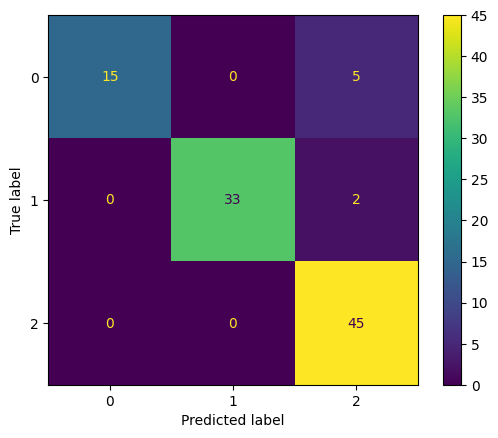

In [19]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

- **Reports**

**We can see, that the model performed pretty well.**
- we have used CatBoost Classifier as it performed well also other model performed well.
- We got a good accuracy while predicting the test dataset.

In [20]:
df.head()

,1h,24h,7d,24h_volume,mkt_cap,volatility
0,0.022,0.030,0.055,35390763321,770991461396,Stable
1,0.024,0.034,0.065,19748695312,327104429349,Stable
2,-0.001,-0.001,0.000,57934969077,79965155138,High
3,0.018,0.028,0.004,1395853984,64043816800,Stable
4,-0.001,0.000,-0.000,3872273611,52222137400,Stable
